<div style="text-align:right">Peter Norvig<br>21 March 2018</div>

# `xkcd` Name Dominoes

The March 21, 2018 `xkcd` comic (#1970) was [Name Dominoes](https://xkcd.com/1970/): domino tiles laid out as if in a game, but the tiles contain names of famous poeple rather than numbers. 
In [dominoes](https://en.wikipedia.org/wiki/Dominoes) each tile has two halves, and a tile can be legally placed only if  one half is adjacent to another tile half with the same number/name, and neither half is adjacent to a tile half with a different number/name. (Exception: the very first tile can be placed anywhere.) 

I will write a function to lay out tiles in a random, legal array.  First, the key data structures:

- **`Tile`**: a tile is a 2-element tuple of names, like `('TIM', 'COOK')`.
The tile `('FRANK LLOYD', 'WRIGHT')` has a space in the first name.
- **`Name`**: a name (first name or last name) is a string.
- **`Board(width, height)`**: a mapping of locations to names.
Initially, all width × height squares on the board are `empty`, but  when we put a tile on the board,
the first name covers one location and the last name covers an adjacent location, e.g. `board[0, 0], board[0, 1] = ('TIM', 'COOK')`.
- **`Location`**: a location is an `(x, y)` pair of coordinates for a square on the board.

In [1]:
empty = None # An empty square

class Board(dict):
    "A mapping from location to name."
    def __init__(self, width=16, height=24): self.width, self.height = width, height
    def __missing__(self, loc): return empty

Now I need a strategy to fill the board with tiles.  I will randomly place tiles one at a time, and to make things easier I will *not* consider removing a tile from the board and backtracking. Some more concepts and functions:

- **`frontier`**: I'll maintain a *frontier*, a set of locations that are adjacent to tiles on the board, and thus are candidates for placing new tiles.
- **`dominoes(tiles)`**: makes a board and places tiles on it, one at a time, until no more can be placed. Chooses a random tile for the first tile, then repeatedly calls `try_one` to legally place an additional tile, stopping when either there is no `frontier` left (meaning no place to legally place a tile) or no `tiles` left to place.
- **`try_one(tiles, board, frontier)`**: pop a location off the frontier, and try to find some tile that can legally put one of its halves there; when found, `put` the tile there, and remove it from `tiles`.
- **`legal(name, loc, board)`**: a name can be placed if the location is empty, and there are no conflicts with any neighboring location.
- **`neighbors(loc, board)`**: returns the (up to 4) neighbors of a location that are on the board.
- **`put_tile(board, loc0, loc1, tile, frontier)`**: places a tile on the board across `loc0` and `loc`; update the `frontier` to say that the just-covered locations are no longer in the frontier, but the empty neighbors of the tile are.
- **`shuffle(items)`**: used to randomize lists; calls `random.shuffle` and returns the result.

In [2]:
import random

def dominoes(tiles, width=16, height=24):
    "Place as many tiles on board as possible (legally and randomly)."
    tiles    = shuffle(list(tiles))
    board    = Board(width, height)
    frontier = set()
    m        = min(width, height) // 2
    put_tile(board, (m, m), (m, m + 1), tiles.pop(), frontier) # Place first tile
    while tiles and frontier:
        try_one(tiles, board, frontier)
    return board
          
def try_one(tiles, board, frontier):
    "Pop a frontier location, and try to place a tile on that location."
    loc0 = frontier.pop()
    for tile in shuffle(tiles):
        for (name0, name1) in [tile, tile[::-1]]:
            if legal(name0, loc0, board):
                for loc1 in shuffle(neighbors(loc0, board)):
                    if legal(name1, loc1, board):
                        put_tile(board, loc0, loc1, (name0, name1), frontier)
                        tiles.remove(tile)
                        return tile
                        
def legal(name, loc, board):
    "Is it legal to place this name on this location on board?"
    return (board[loc] is empty and
            all(board[nbr] is empty or board[nbr] == name
                for nbr in neighbors(loc, board)))

def neighbors(loc, board):
    "Neighbors of this location on the board."
    x, y = loc
    nbrs = [(x, y+1), (x, y-1), (x+1, y), (x-1, y)]
    return [(X, Y) for (X, Y) in nbrs
            if 0 <= X < board.width and 0 <= Y < board.height]

def put_tile(board, loc0, loc1, tile, frontier): 
    "Place the tile across the two locations, and update frontier."
    board[loc0], board[loc1] = tile
    frontier -= {loc0, loc1}
    frontier |= {loc for loc in neighbors(loc0, board) + neighbors(loc1, board)
                 if board[loc] is empty}
                            
def shuffle(items): random.shuffle(items); return items

In [3]:
tiles8 = [('BO', 'JA'), ('JA', 'PO'), ('JA', 'RY'), ('RY', 'KE'), 
          ('GR', 'KE'), ('GR', 'JO'), ('JA', 'KE'), ('KE', 'JO')]

dominoes(tiles8, 6, 6)

{(0, 2): 'GR',
 (0, 3): 'JO',
 (1, 1): 'BO',
 (1, 3): 'JO',
 (1, 4): 'KE',
 (2, 1): 'JA',
 (2, 4): 'KE',
 (2, 5): 'GR',
 (3, 0): 'JA',
 (3, 1): 'JA',
 (3, 2): 'RY',
 (3, 3): 'RY',
 (3, 4): 'KE',
 (4, 0): 'PO',
 (4, 4): 'KE',
 (5, 4): 'JA'}

# Pretty Output

There are two problems with this output. One, it is not visual. Two, it doesn't say where each tile is: when three names come together, which of the outside names goes with the middle name?  To fix those two problems I will:

- Use `matplotlib` to plot a less-ugly display; encapsulate this in the function `plot_board(board)`.
- Modify the `Board` class and the `put` function so that the board maintains a list of `boxes` that surround each two-location rectangle that a tile occupies. A box is a 4-tuple, `(x0, y0, x1, y1)`, holding the `x, y` coordinates
of the upper-left and lower-right corners of a box. The function `plot_box(box)` plots the rectangle. Note that in the new last line of `put_tile`, I add just `0.94`, not `1.0` to the size of the box; this way two adjacent tiles won't quite touch (as in the xkcd comic).

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

ϵ = 0.06 # A small amount; the space between adjacent lines

def plot_board(board, figsize=(16, 24)):
    "Plot the box and name for every tile, plus a big box around the board."
    plt.figure(figsize=figsize)
    plt.axis('off')  
    plt.axis('equal')
    for box in board.boxes:
        plot_box(box)
    for (x, y) in board:
        plt.text(x + 0.5, y + 0.3, board[x, y], ha='center', fontsize=8)
    plot_box((-2*ϵ, -2*ϵ, figsize[0] + ϵ, figsize[1] + ϵ))

def plot_box(box):
    "Plot a box."
    x0, y0, x1, y1 = box
    plt.plot([x0, x1, x1, x0, x0], 
             [y0, y0, y1, y1, y0], 'k-')
                
class Board(dict):
    "A mapping from location to name."
    def __init__(self, width=16, height=24): 
        self.width, self.height, self.boxes = width, height, []
    def __missing__(self, loc): return empty
    
def put_tile(board, loc0, loc1, tile, frontier): 
    "Place the tile across the two locations, and update frontier and boxes."
    board[loc0], board[loc1] = tile
    frontier -= {loc0, loc1}
    frontier |= {loc for loc in neighbors(loc0, board) + neighbors(loc1, board)
                 if board[loc] is empty}
    (x0, y0), (x1, y1) = loc0, loc1
    board.boxes.append((min(x0, x1), min(y0, y1), 
                        max(x0, x1) + 1 - ϵ, max(y0, y1) + 1 - ϵ))        

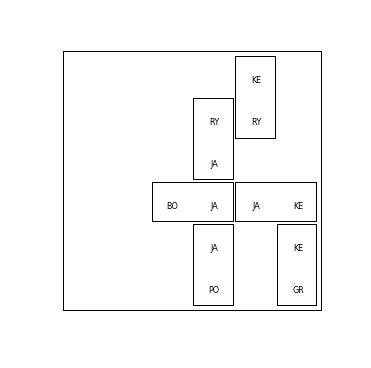

In [5]:
plot_board(dominoes(tiles8, 6, 6), (6, 6))

# All the Names

Now let's try all the names from the comic, courtesy of 
 [explainxkcd](http://www.explainxkcd.com/wiki/index.php/1970:_Name_Dominoes), with a few typos corrected:

In [6]:
def split_names(text):
    "For each line of text, create a tile of ('First Name(s)', 'Lastname')."
    return [name.strip().rpartition(' ')[0::2]
            for name in text.upper().split(',')]
           
xkcdtiles = split_names("""Christian Campbell, Neve Campbell, Joe McCarthy, Eugene McCarthy, 
  Gene Vincent, Gene Kelly, Kate Hudson, Rock Hudson, Gordon Brown, James Brown, Jon Brown, 
  John Howard, Columbo, Chris Columbus, Christopher Columbus, Naomi Campbell, Joseph Campbell, 
  Joseph Smith, Frank Vincent, John Kelly, Katherine Johnson, The Rock, Chris Rock, Chris Isaac, 
  James Newton Howard, John Wayne, Howard Stern, Howard Hunt, Chris Hughes, Naomi Watts, 
  Naomi Klein, Kevin Kline, Francis Bacon, Francis Drake, Lyndon Johnson, Oscar The Grouch, 
  Oscar Isaac, Isaac Hayes, Isaac Newton, Wayne Newton, Wayne Knight, Helen Hunt, Helen Hughes, 
  James Watt, James Watt, Kevin Costner, Kevin Bacon, Kevin Love, Lisa Frank, Frank Drake, Drake, 
  Oscar de la Renta, Oscar de la Hoya, Sean Hayes, Wallace Shawn, Wayne Howard, Wayne Brady, 
  James Brady, Tom Brady, Helen Thomas, Tom Hanks, Hank Aaron, Aaron Carter, Stephen James, 
  Will Smith, Kevin Smith, Kevin James, Garfield, James Garfield, Warren Buffett, Jimmy Buffett, 
  Warren Beatty, Elizabeth Warren, Earl Warren, Elizabeth Kolbert, Stephen Colbert, George Wallace,
  Charles Wallace, James Monroe, Marilyn Monroe, Hank Williams, William C. Williams, Steve Harvey,
  Domino Harvey, Harvey Milk, James Saint James, Etta James, Jim Jones, James Earl Jones, 
  Charlie Parker, Ray Parker, Ray Charles, Charles Manson, Marilyn Manson, Robin Williams, 
  Billy D. Williams, Will Wright, Fats Domino, Bill Clinton, Jimmy John, Tom Jones, Tommy John, 
  Quincy Jones, James Earl Ray, Man Ray, Rachel Ray, Ray Allen, Tim Allen, Tim Cook, Tim Howard, 
  Robin Wright, Wilbur Wright, Fatty Arbuckle, Fat Joe, George Clinton, John Kerry, 
  Kerry Washington, John Irving, John Quincy Adams, John Adams, Amy Adams, Aimee Mann, Super Man, 
  Bat Man, Ayn Rand, Lily Allen, Paul Allen, Ron Howard, Howard Hughes, Joe Kennedy, George Bush, 
  George Washington, Washington Irving, Martha Washington, Ma Rainey, Jack Ma, Super Grover, 
  Jack Black, Rand Paul, Paul Ryan, Paul Simon, Ron Paul, John Hughes, Langston Hughes, 
  John F. Kennedy, Little Richard, Rich Little, Martha Stewart, Yo Yo Ma, Ma Bell, 
  Grover Cleveland Alexander, Grover Cleveland, Jack White, Jack Ryan, Debby Ryan, Carly Simon, 
  Carly Hughes, Charles Evans Hughes, John Williams, Little John, Stuart Little, Potter Stewart, 
  Kristen Stewart, Kristen Bell, Kristen Hooks, Alexander Graham Bell, Franklin Graham, 
  Lloyd Alexander, Meg White, Meg Ryan, Debbie Reynolds, John Reynolds, Carly Fiorina, 
  Grace Lee Boggs, Wade Boggs, William Safire, Prince William, Little Prince, Harry Potter, 
  James Potter, James Hook, James Dean, Aretha Franklin, Frank Lloyd Wright, Barry White, 
  Walter White, Walt Whitman, John Kelly, Grace Lee, Nancy Grace, Garnet, Prince, Prince Fielder, 
  Prince Harry, Harry Styles, John Dean, Benjamin Franklin, Harold Lloyd, Harold Ford, 
  Betty White, Meg Whitman, Christine Todd Whitman, Megyn Kelly, Grace Kelly, Grace Jones, 
  Jack Nicholson, Jack Ruby, Jack Russell, Harry Fielder, Harry Truman, Harry Jon Benjamin, 
  John Edward, Benjamin Harrison, Harrison Ford, Henry Ford, Betty Ford, Betty Friedan, 
  Chris Christie, Chris Pratt, Maggie Grace, Grace Hopper, Russell Crowe, Russ Smith, John Smith, 
  Justin Long, John Bel Edwards, John Candy, John Henry, Henry James, Bill James, Chris Cooper, 
  Chris Hemsworth, Chris Evans, Topher Grace, Van Morrison, Sheryl Crow, Sheryl Sandberg, 
  Cameron Crowe, Long John Silver, Olivia Newton John, Huey Long, John Edwards, Candy Crowley, 
  Aleister Crowley, James Fenimore Cooper, James Cook, Robert Frost, Bob Evans, Evan Taylor Jones,
  James Cameron, Cam Newton, Cameron Diaz, Huey Newton, Huey Lewis, John Lewis, Jenny Lewis, 
  Ryan Lewis, Burt Reynolds, Alistair Cooke, Alistair Cookie, Cokie Roberts, John Roberts, 
  Robert Johnson, Robert E. Lee, Tommy Lee, Tommy Lee Jones, Etta James, John Oliver, 
  Ryan Reynolds, Alastair Reynolds""")

In [7]:
len(xkcdtiles)

270

In [8]:
random.sample(xkcdtiles, 9)

[('VAN', 'MORRISON'),
 ('HARRY JON', 'BENJAMIN'),
 ('AIMEE', 'MANN'),
 ('JOE', 'MCCARTHY'),
 ('JOHN', 'ADAMS'),
 ('CHRIS', 'HEMSWORTH'),
 ('EUGENE', 'MCCARTHY'),
 ('OSCAR THE', 'GROUCH'),
 ('SUPER', 'GROVER')]

# Approximate and Partial Matches

Two tile halves match if they are an exact match, like "ADAMS" and "ADAMS", or if they are an **approximate match**, like "AMY" and "AIMEE". To accomodate this, you can manually define allowable approximate matches by making the global variable `synsets` (synonym sets) be a mapping from a name to the set of approximate matches it should match, which can be done like this:

     synsets = synonyms("AMY=AIMEE, COOK=COOKE=COOKIE=COKIE, ...")

Another issue is  a **partial match**: in the comic, some tiles, like "FRANK LLOYD WRIGHT" are 3 squares wide, and some, like "PRINCE" are only one square wide. For simplicity, I chose to have all my tiles be 2 squares wide, but I still want `'LLOYD'` to match the first name of `('FRANK LLOYD', 'WRIGHT')`. To accomplish this, the second argument to `synonyms` is a list of tiles; the function will go through these and add synset entries for parts of first names,
so that both `'FRANK'` and `'LLOYD'` will match `'FRANK LLOYD'`. As for "PRINCE", he gets represented as the tile `('', 'PRINCE')`. 

In [9]:
import collections

def synonyms(text, tiles=()): 
    "synonyms('AMY=AIMEE') => dict(AMY={'AMY', 'AIMEE'}, AIMEE={'AMY', 'AIMEE'})"
    synsets = collections.defaultdict(set)
    # Process `text`
    for text1 in text.upper().split(','):
        synset = set(text1.strip().split('='))
        for s in synset:
            synsets[s] |= synset
    # Process `tiles`
    for (first, last) in tiles:
        if ' ' in first:
            for piece in first.split():
                synsets[piece].add(first)
                synsets[first].add(piece)
    return synsets

synsets = synonyms("""AMY=AIMEE, COOK=COOKE=COOKIE=COKIE, ALASTAIR=ALISTAIR, 
  COLUMBO=COLUMBUS, SAFIRE=SAPPHIRE=GARNET, GARNET=RUBY, CHARLIE=CHARLES, SEAN=SHAWN,
  JIMMY=JAMES, MAN=MANN, JACK=JOHN, TOM=TOMMY, WILL=WILLIAM=WILLIAMS, ROBERT=ROBERTS=BOB, 
  CAM=CAMERON, OLIVER=OLIVIA, EDWARD=EDWARDS, RICH=RICHARD, CHRIS=CHRISTOPHER=TOPHER, 
  FAT=FATS=FATTY, WALT=WALTER, HANK=HANKS, CROW=CROWE""", xkcdtiles)

To make this work, I update `legal` to call the new function `match_neighbor` for each neighbor; this checks for empties and exact matches just like before, but it also consults the `synsets` global variable for an approximate or partial match, and it disallows a match between the empty first name of "PRINCE" with the empty first name of "DRAKE".

In [10]:
def legal(name, loc, board):
    "Is it legal to place this value on this location on board?"
    return (board[loc] is empty and
            all(match_neighbor(name, board[nbr]) for nbr in neighbors(loc, board)))

def match_neighbor(name, nbrval):
    "Does this name match the neighbor's value?"
    return (nbrval is empty or 
            nbrval == name != '' or
            nbrval in synsets[name])

# Random Restart

The program sometimes gets stuck after placing a relatively small number of tiles. I could modify the program to *back up* in this case, but it will be easier to just *give up* and restart with an empty board. I can restart multiple times, and accept the board on which the most tiles were placed. The function `restart_dominoes` does this. 

In [11]:
def restart_dominoes(tiles, width=16, height=24, restarts=100):
    return max((dominoes(tiles, width, height) for _ in range(restarts)), 
                key=lambda board: len(board.boxes))

# Final Results

Let's see what we can generate, and compare it to the original comic. *Note:* By default, I'm using a 16×24 square board; the xkcd comic uses 27×35, but if I try to fit that many then each tile will be smaller, and the names overflow the sides of the dominoes too much. (As it is, only a few names overflow.)

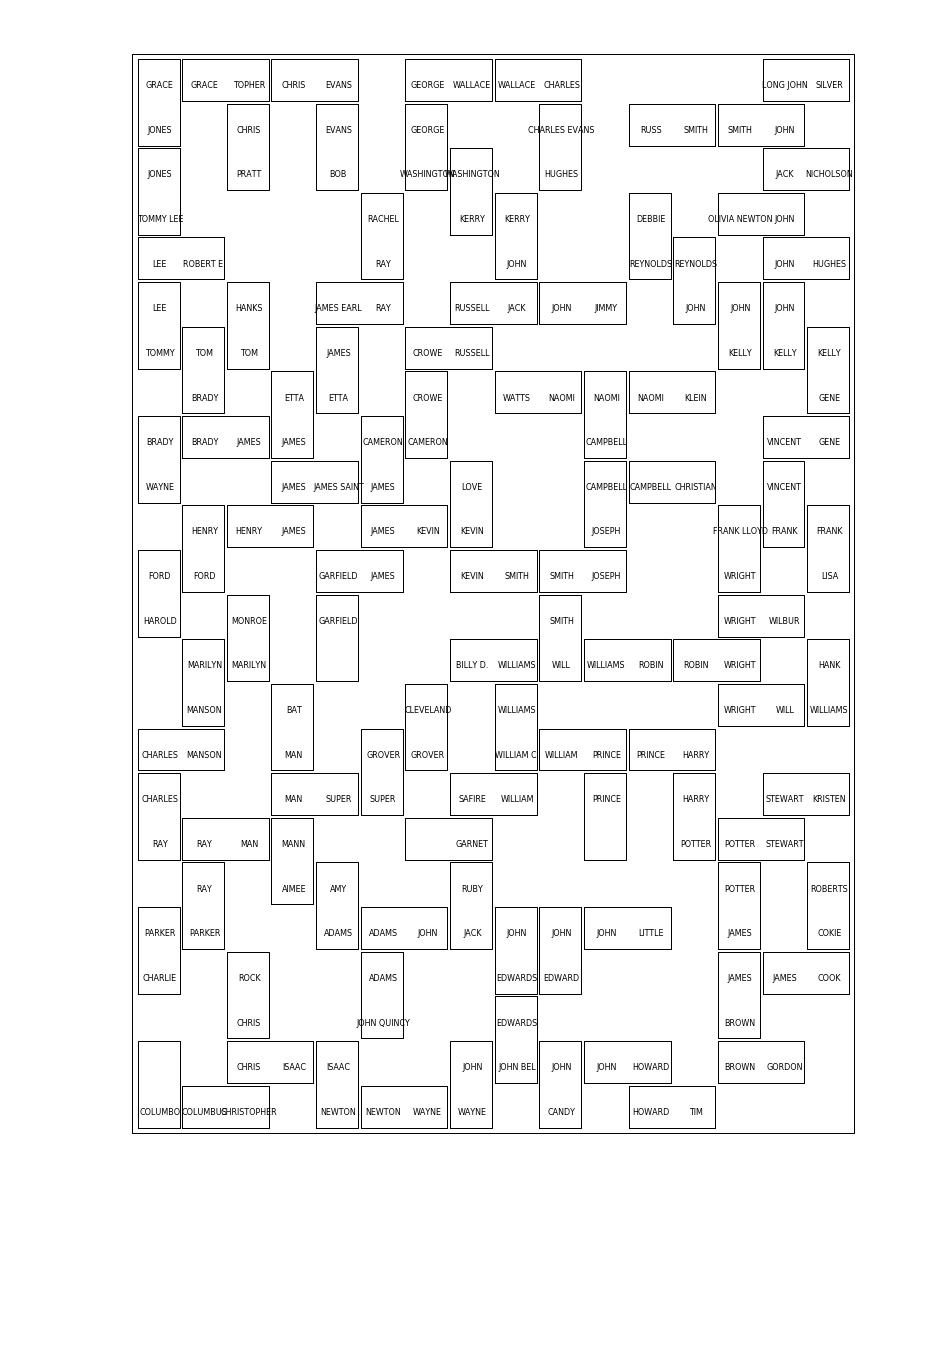

In [12]:
plot_board(restart_dominoes(xkcdtiles))

![](https://imgs.xkcd.com/comics/name_dominoes_2x.png)

# What's Next?

I'm happy with the results, but here are some ideas for improvements, if you want something to work on:
- Allow tiles that are 1 or 3 squares wide, like `('PRINCE',)` or `('FRANK', 'LLOYD', 'WRIGHT')`.
- Print names vertically in tiles that are placed vertically, and upside down for tiles that are placed horizontally, but with the first name on the right.
- Print shorter names with a bigger font and longer names with a smaller font.
- Download a bunch of names from Wikipedia and fill a 200 × 300 board.
